# FigureOneLabs: Proper acquisition of cell class identity in organoids allows definition of fate specification programs of the human cerebral cortex (Uzquiano, 2022)

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import pybiomart
import scvi
import torch
import random
import seaborn as sns
import celltypist
from celltypist import models

/Users/laurahuggon/PycharmProjects/figureonelab/venv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/laurahuggon/PycharmProjects/figureonelab/venv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/Users/laurahuggon/PycharmProjects/figureonelab/venv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/Users/laurahuggon/PycharmProjects/figureonelab/venv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/Users/laurahuggon

In [2]:
# Define directories
outs_dir = '../outs'

In [3]:
# Create an account for Broad Single Cell Portal
# Download data from https://singlecell.broadinstitute.org/single_cell/study/SCP1756/cortical-organoids-atlas#study-download

## Metadata preparation

This experiment compares developing cortical organoids at 8 time points. For simplicity, we will focus on organoids analysed at 23 days (29,736 cells from 2 cell lines (PGP1 c1 and Mito210 c1), 6 organoids).

Read in the metadata file and prepare the dataframe.

In [4]:
# Load metadata
meta = pd.read_csv('../data/meta_all.txt', sep='\t') # Specify that the file is tab-separated
meta

/var/folders/tj/nksd2rpd1zv9gsz28dlj1r0c0000gn/T/ipykernel_1182/165542562.py:2: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('../data/meta_all.txt', sep='\t') # Specify that the file is tab-separated


,NAME,biosample_id,donor_id,nGene,nUMI,sex,species,species__ontology_label,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,biosample_type
0,TYPE,group,group,numeric,numeric,group,group,group,group,group,group,group,group,group,group
1,AAACGAAAGACACAAT-3_1m-ATAC,ATAC-Org3,Mito 210 c1 b5,3850,5327,male,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0010891,scATAC-seq,DerivedType_Organoid
2,AAACGAAAGACCTATC-1_1m-ATAC,ATAC-Org1,Mito 210 c1 b5,2070,2556,male,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0010891,scATAC-seq,DerivedType_Organoid
3,AAACGAAAGATTGACA-2_1m-ATAC,ATAC-Org2,Mito 210 c1 b5,2708,3334,male,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0010891,scATAC-seq,DerivedType_Organoid
4,AAACGAAAGCGTCTGC-1_1m-ATAC,ATAC-Org1,Mito 210 c1 b5,3970,5339,male,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0010891,scATAC-seq,DerivedType_Organoid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777088,PCW18_TTTGTTGGTCACCGAC-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,2298,5225,unknown,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0008995,10X sequencing,PrimaryBioSample_Tissue
777089,PCW18_TTTGTTGGTGACAGCA-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,6308,24794,unknown,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0008995,10X sequencing,PrimaryBioSample_Tissue
777090,PCW18_TTTGTTGGTTAGAAAC-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,1142,2062,unknown,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0008995,10X sequencing,PrimaryBioSample_Tissue
777091,PCW18_TTTGTTGTCACCCTTG-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,2881,7919,unknown,NCBITaxon:9606,Homo sapiens,PATO_0000461,normal,UBERON:0000955,brain,EFO:0008995,10X sequencing,PrimaryBioSample_Tissue


In [5]:
# Drop the first row of the dataframe
meta.drop(index=0, axis=0, inplace=True) # index=0 specifies the row to drop, axis=0 indicates that it is a row, inplace=True modifies the dataframe rather than returning a new dataframe
# Drop the specified columns
meta.drop(columns=['species','species__ontology_label',
                   'disease','disease__ontology_label',
                   'organ','organ__ontology_label',
                   'library_preparation_protocol'], inplace=True) # List of columns to drop
# Rename the specified columns using a dictionary where the keys are current column names and values are the new names
meta.rename(columns={'NAME':'CellID', 'biosample_id':'SampleID'}, inplace=True)
print(meta.shape) # Determine how big the table is - 777,092 cells
meta

(777092, 8)


,CellID,SampleID,donor_id,nGene,nUMI,sex,library_preparation_protocol__ontology_label,biosample_type
1,AAACGAAAGACACAAT-3_1m-ATAC,ATAC-Org3,Mito 210 c1 b5,3850,5327,male,scATAC-seq,DerivedType_Organoid
2,AAACGAAAGACCTATC-1_1m-ATAC,ATAC-Org1,Mito 210 c1 b5,2070,2556,male,scATAC-seq,DerivedType_Organoid
3,AAACGAAAGATTGACA-2_1m-ATAC,ATAC-Org2,Mito 210 c1 b5,2708,3334,male,scATAC-seq,DerivedType_Organoid
4,AAACGAAAGCGTCTGC-1_1m-ATAC,ATAC-Org1,Mito 210 c1 b5,3970,5339,male,scATAC-seq,DerivedType_Organoid
5,AAACGAAAGGATATCA-3_1m-ATAC,ATAC-Org3,Mito 210 c1 b5,2590,3279,male,scATAC-seq,DerivedType_Organoid
...,...,...,...,...,...,...,...,...
777088,PCW18_TTTGTTGGTCACCGAC-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,2298,5225,unknown,10X sequencing,PrimaryBioSample_Tissue
777089,PCW18_TTTGTTGGTGACAGCA-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,6308,24794,unknown,10X sequencing,PrimaryBioSample_Tissue
777090,PCW18_TTTGTTGGTTAGAAAC-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,1142,2062,unknown,10X sequencing,PrimaryBioSample_Tissue
777091,PCW18_TTTGTTGTCACCCTTG-1_fetal,Fetal-4-PCW18,Fetal-4-PCW18,2881,7919,unknown,10X sequencing,PrimaryBioSample_Tissue


How many cells were analysed for each experiment (determined by protocol and sample type)?

In [6]:
# Select the two columns and count unique combinations
meta[['library_preparation_protocol__ontology_label','biosample_type']].value_counts()

library_preparation_protocol__ontology_label  biosample_type         
10X sequencing                                DerivedType_Organoid       601747
                                              PrimaryBioSample_Tissue     60806
single cell sequencing                        DerivedType_Organoid        53232
scATAC-seq                                    DerivedType_Organoid        38017
Slide-seq                                     DerivedType_Organoid        23290
Name: count, dtype: int64

Identify what samples can be found in the dataframe.

In [7]:
# Find the unique values of the SampleID column
meta['SampleID'].unique()

array(['ATAC-Org3', 'ATAC-Org1', 'ATAC-Org2', 'ATAC-Org5', 'ATAC-Org6',
       'ATAC-Org4', 'ATAC-Org8', 'ATAC-Org9', 'ATAC-Org7',
       'SlideSeq-1m-Org1', 'SlideSeq-1m-Org2', 'SlideSeq-1m-Org4',
       'SlideSeq-1m-Org3', 'SlideSeq-2m-Org1', 'SlideSeq-2m-Org2',
       'SlideSeq-2m-Org3', 'SlideSeq-3m-Org1', 'SlideSeq-3m-Org2',
       'SlideSeq-3m-Org3', 'Org1', 'Org2', 'Org3', 'Org4', 'Org5', 'Org6',
       'Org7', 'Org8', 'Org9', 'Org10', 'Org11', 'Org12', 'Org13',
       'Org14', 'Org15', 'Org16', 'Org17', 'Org18', 'Org19', 'Org20',
       'Org21', 'Org22', 'Org23', 'Org24', 'Org25', 'Org26', 'Org27',
       'Org28', 'Org29', 'Org30', 'Org31', 'Org32', 'Org33', 'Org40',
       'Org41', 'Org42', 'Org43', 'Org44', 'Org45', 'Org34', 'Org35',
       'Org36', 'Org37', 'Org38', 'Org39', 'Org46', 'Org47', 'Org48',
       'Org49', 'Org50', 'Org51', 'Org55', 'Org56', 'Org57', 'Org52',
       'Org53', 'Org54', 'Org58', 'Org59', 'Org60', 'Org61', 'Org62',
       'Org63', 'Org64', 'Org65', 'O

### Filter the metadata

Read in the file that contains the barcodes for each cell analysed at 23 days.

In [8]:
barcodes = pd.read_csv('../data/NormExpression_23days_barcodes.txt', sep='\t', header=None) # Specify that the file does not have a header row
# Rename the column
barcodes.rename(columns={0:'CellID'}, inplace=True)
print(barcodes.shape) # Determine how big the table is - 29,736 cells
barcodes

(29736, 1)


,CellID
0,1_AAACGAACACGTGAGA-1_1_23d
1,1_AAACGAAGTCGAAACG-1_1_23d
2,1_AAACGAAGTGGCAGAT-1_1_23d
3,1_AAACGAAGTGGTTCTA-1_1_23d
4,1_AAACGAAGTTGGCCGT-1_1_23d
...,...
29731,3_TTTGGTTTCGGAATGG-1_2_23d
29732,3_TTTGGTTTCGGTTAGT-1_2_23d
29733,3_TTTGTTGAGACCATAA-1_2_23d
29734,3_TTTGTTGAGAGAAGGT-1_2_23d


Count the number of cells in the `barcode` dataframe that also exist in the `meta` dataframe (i.e. count the number of cells in the `barcode` dataframe that we have metadata for).

In [9]:
# Check each element in the CellID column of barcodes to see if it is present in the CellID column of meta
# This returns a boolean Series of the same length as barcodes['CellID'], where each element is True if the corresponding CellID is found in meta[`CellID`]
barcodes['CellID'].isin(meta['CellID'])

0        True
1        True
2        True
3        True
4        True
         ... 
29731    True
29732    True
29733    True
29734    True
29735    True
Name: CellID, Length: 29736, dtype: bool

In [10]:
# Sum the True values in the boolean Series (where True is treated as 1 and False is treated as 0)
sum(barcodes['CellID'].isin(meta['CellID'])) # 29,736 cells have metadata (i.e. all the cells)

29736

Create a filtered `meta` dataframe that contains only the cells analysed at 23 days.

In [11]:
# Check if each CellID in the meta dataframe exists in the barcodes dataframe, returning a boolean Series
a = meta['CellID'].isin(barcodes['CellID'])
# Use the boolean Series, a, to filter the rows of the meta dataframe - only rows where a is True are selected
b = meta[a]
# Merge the barcodes dataframe with the filtered meta dataframe based on the CellID column
# This is a left join, meaning all rows in the barcodes dataframe are kept, and matching rows from b are included
# If there is no match in b, the resulting dataframe will have NaN for these columns
meta_d23 = pd.merge(barcodes, b, on='CellID', how='left')
print(meta_d23.shape) # Determine how big the table is - 29,736 cells
meta_d23

(29736, 8)


,CellID,SampleID,donor_id,nGene,nUMI,sex,library_preparation_protocol__ontology_label,biosample_type
0,1_AAACGAACACGTGAGA-1_1_23d,Org1,Mito 210 c1 b1,536,3724,male,10X sequencing,DerivedType_Organoid
1,1_AAACGAAGTCGAAACG-1_1_23d,Org1,Mito 210 c1 b1,2310,9184,male,10X sequencing,DerivedType_Organoid
2,1_AAACGAAGTGGCAGAT-1_1_23d,Org1,Mito 210 c1 b1,2070,6359,male,10X sequencing,DerivedType_Organoid
3,1_AAACGAAGTGGTTCTA-1_1_23d,Org1,Mito 210 c1 b1,1292,3468,male,10X sequencing,DerivedType_Organoid
4,1_AAACGAAGTTGGCCGT-1_1_23d,Org1,Mito 210 c1 b1,832,1809,male,10X sequencing,DerivedType_Organoid
...,...,...,...,...,...,...,...,...
29731,3_TTTGGTTTCGGAATGG-1_2_23d,Org6,PGP1 c1 b2,995,1825,male,10X sequencing,DerivedType_Organoid
29732,3_TTTGGTTTCGGTTAGT-1_2_23d,Org6,PGP1 c1 b2,3449,13964,male,10X sequencing,DerivedType_Organoid
29733,3_TTTGTTGAGACCATAA-1_2_23d,Org6,PGP1 c1 b2,1382,3670,male,10X sequencing,DerivedType_Organoid
29734,3_TTTGTTGAGAGAAGGT-1_2_23d,Org6,PGP1 c1 b2,1331,3713,male,10X sequencing,DerivedType_Organoid


In [12]:
del meta
del a
del b

### Inspect the metadata

For the day 23 metadata, how many cells were analysed for each experiment (determined by protocol and sample type)?

In [13]:
# Select the two columns and count unique combinations
meta_d23[['library_preparation_protocol__ontology_label','biosample_type']].value_counts() # 10X sequencing on organoids - 29,736 cells

library_preparation_protocol__ontology_label  biosample_type      
10X sequencing                                DerivedType_Organoid    29736
Name: count, dtype: int64

Check if cells were balanced across experimental conditions (determined by organoid and cell line). It may make certain comparisons difficult otherwise.

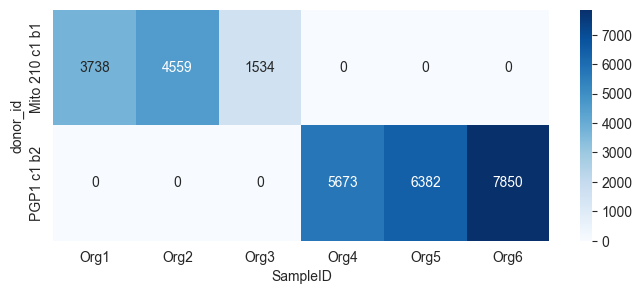

In [14]:
plt.figure(figsize=(8,3))
# Create a pivot table showing the number of cells used across experimental conditions
# Since we want to count occurrences, any column can be used for values
# aggfunc=len specifies that the aggregation function used to combine values will be the length (or count) of the values i.e. count the number of occurrences of each combination of SampleID and donor_id
pivot = meta_d23.pivot_table(columns='SampleID', index='donor_id', values='CellID', aggfunc=len)
# Convert the values in the pivot table to integers, filling any NaN values with 0
pivot = pivot.fillna(0).astype(int)
# Plot as a heatmap
sns.heatmap(pivot, annot=True, cmap='Blues', fmt='d'); # The same number of organoids were used per cell line

How many cells were analysed per organoid?

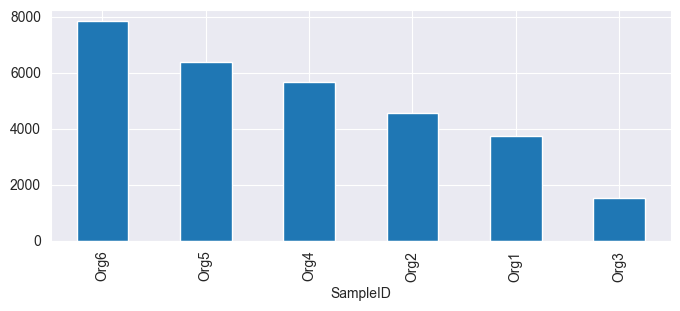

In [15]:
plt.figure(figsize=(8,3))
meta_d23['SampleID'].value_counts().plot.bar(); # There is a range of how many cells were analysed per organoid

How many cells were analysed per cell line?

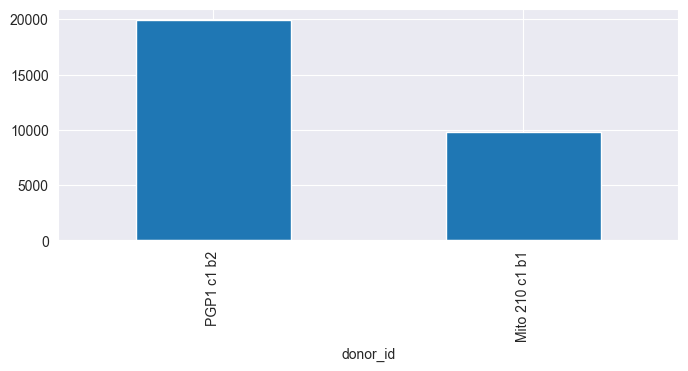

In [16]:
plt.figure(figsize=(8,3))
meta_d23['donor_id'].value_counts().plot.bar(); # The PGP1 c1 b2 cell line contributed twice as many cells to the dataset

## Data preparation

Read in the **raw count** matrix for 23 days RNA-seq data.

*Notes:*
* **Matrix Market file:** a standardised file format for storing matrices, especially sparse ones, used for efficient storage and exchange.
* **Sparse matrix:** a matrix predominantly composed of zero elements, stored in specialised formats to save memory and improve computational efficiency.
* **Compressed Sparse Row (CSR) format:** a popular method for storing sparse matrices efficiently. This format is particularly advantageous for arithmetic operations, row slicing, and matrix-vector products.

In [17]:
# Load row count matrix
counts = scipy.io.mmread('../data/expression_23days.txt') # scipy.io.mmread is function from the scipy library that reads a Matrix Market file and returns a sparse matrix
# Transpose the matrix (swap its rows and columns)
counts = counts.transpose()
# Convert the transposed matrix to a CSR format
counts = scipy.sparse.csr_matrix(counts)
# Returns the shape of the matrix as a tuple, representing the number of rows and columns
counts.shape # Determine how big the table is - 29,736 cells x 33,694 genes

(29736, 33694)

Read in the file that contains the genes analysed at 23 days.

In [18]:
genes = pd.read_csv('../data/NormExpression_23days_genes.txt', sep='\t', header=None)
# Rename the column
genes.rename(columns={0:'Genes'}, inplace=True)
print(genes.shape) # Determine how big the table is - 33,694 genes
genes

(33694, 1)


,Genes
0,RP11-34P13.3
1,FAM138A
2,OR4F5
3,RP11-34P13.7
4,RP11-34P13.8
...,...
33689,AC233755.2
33690,AC233755.1
33691,AC240274.1
33692,AC213203.1


Create a pandas DataFrame of the count matrix that can be used to inspect the data - cells are in rows, genes as columns.

In [19]:
# Convert to dense format
dense_counts = counts.toarray()
# Convert the numpy array to a pandas DataFrame
pd_counts = pd.DataFrame(dense_counts)
type(pd_counts)

pandas.core.frame.DataFrame

In [20]:
del dense_counts

In [21]:
pd_counts.iloc[:5, :5]

,0,1,2,3,4
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [22]:
# Convert barcodes to a list
# .squeeze() coverts a single-column DataFrame to a Series
# .tolist() converts a Series to a list
barcodes_list = barcodes.squeeze().tolist()
# Convert genes to a list
genes_list = genes.squeeze().tolist()
# Set the row labels (index) using the cell barcodes
pd_counts.index = barcodes_list
# Set the column labels (columns) using the gene names
pd_counts.columns = genes_list
pd_counts.iloc[:5, :5]

,RP11-34P13.3,FAM138A,OR4F5,RP11-34P13.7,RP11-34P13.8
1_AAACGAACACGTGAGA-1_1_23d,0,0,0,0,0
1_AAACGAAGTCGAAACG-1_1_23d,0,0,0,0,0
1_AAACGAAGTGGCAGAT-1_1_23d,0,0,0,0,0
1_AAACGAAGTGGTTCTA-1_1_23d,0,0,0,0,0
1_AAACGAAGTTGGCCGT-1_1_23d,0,0,0,0,0


In [23]:
del barcodes_list
del genes_list

### Inspect the data 

The dataframe contains a lot of zeros. A gene can be zero if that gene in not expressed in that cell - or - if for some reason the gene is not picked up. Single cell transcriptomics, compared to bulk transcriptomics, has to work with very little RNA - and hence - it's sensitivity is much lower. It is expected that most of the dataset is zero.

Which genes express highly overall?

In [24]:
# Sum per gene then sort by descending
pd_counts.sum().sort_values(ascending=False).head()

MALAT1    7400471
MT-CO2    2540757
MT-CO1    1835915
RPL10     1798331
RPS12     1442832
dtype: int64

Then check the values of a few genes across all cells - we have a much better chance to see genes express now.

In [25]:
pd_counts[['MALAT1', 'MT-CO2', 'EMX1']].head()

,MALAT1,MT-CO2,EMX1
1_AAACGAACACGTGAGA-1_1_23d,2,26,0
1_AAACGAAGTCGAAACG-1_1_23d,167,125,0
1_AAACGAAGTGGCAGAT-1_1_23d,551,113,0
1_AAACGAAGTGGTTCTA-1_1_23d,291,65,1
1_AAACGAAGTTGGCCGT-1_1_23d,513,2,0


Note, these are all integers - as you would expect dealing with raw counts.

Create a density plot to check individual gene expression. A Kernel Density Estimate (KDE) plot visualises the distribution of expression levels of specific genes, allowing us to see how the expression levels are distributed across the samples.

*Notes:*
* The x-axis represents the gene expression levels and the y-axis represents the estimated density (probability) of these expression levels.
* Higher values on the y-axis indicate that there are more samples with expression levels around the corresponding value on the x-axis.

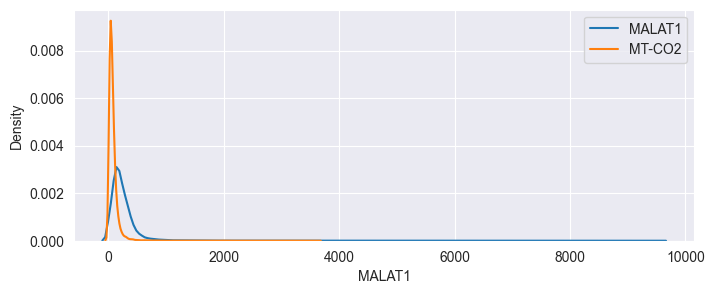

In [26]:
plt.figure(figsize=(8,3))
sns.kdeplot(pd_counts['MALAT1'], label='MALAT1')
sns.kdeplot(pd_counts['MT-CO2'], label='MT-CO2')
plt.legend();

In [27]:
del pd_counts

## Preprocessing and QC

Combine the expression data (`counts`), cell metadata (`meta_d23`), and gene metadata (`genes`) into a single `AnnData` object (Scanpy object). This is commonly used for handling annotated data matrices, particularly in single-cell transcriptomics.

*Notes:*
* The main attributes of an AnnData structure:
    * `adata.X` is a matrix with the counts.
    * `adata.obs` contains the per cell metadata.
    * `adata.var` contains per gene metadata.

In [28]:
# Create an AnnData object
adata = anndata.AnnData(X=counts, # The raw counts matrix, counts, is the expression data
                        obs=meta_d23, # The observation annotations, meta_d23, contains metadata about the observations (cells)
                        var=genes) # The variable annotations, genesœ, contains metadata about the variables (genes)
# Printing adata shows what it knows:
#   29,736 cells (obs)
#   33,694 genes (vars)
#   Metadata fields per cell (obs)
adata

AnnData object with n_obs × n_vars = 29736 × 33694
    obs: 'CellID', 'SampleID', 'donor_id', 'nGene', 'nUMI', 'sex', 'library_preparation_protocol__ontology_label', 'biosample_type'
    var: 'Genes'

Update the variable names (gene identifiers) in `adata` to the values found in the `Genes` column of the `adata.var` dataframe.

In [29]:
# adata.var_names is an attribute of the AnnData object that contains the names of the variables in the dataset - it is a list/index object that holds the identifiers for each gene
# adata.var['Genes'] accesses the Genes column in the adata.var dataframe
adata.var_names = adata.var['Genes']

### QC stats

Scanpy provides a utility function that gathers a number of quality-related statistics such as:
* Number of reads and unique genes per cell.
* Number of mitochondrial and ribosomal reads per cell.

In [30]:
# Identify mitochondrial genes based on the prefix "MT-"
# adata.var["mt"] creates a new column named "mt" in the adata.var dataframe which will fill with booleans
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# Identify ribosomal genes based on the prefixes "RPS" and "RPL"
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# Calculate quality control metrics based on mitochondrial and ribosomal gene annotations
# qc_vars=["mt", "ribo"] specifies the columns that indicate mitochondrial and ribosomal genes
# log1p=True applies the natural logarithm (log1p) transformation to the quality control metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True # Modify the adata object in place
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [31]:
adata # Several QC metric columns have been added

AnnData object with n_obs × n_vars = 29736 × 33694
    obs: 'CellID', 'SampleID', 'donor_id', 'nGene', 'nUMI', 'sex', 'library_preparation_protocol__ontology_label', 'biosample_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'Genes', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

Inspect violin plots to see some of the computed QC metrics. These plots are important to understand the quality of the data.
* `n_genes_by_counts`: the number of genes (with at least 1 count) detected per cell. Low gene detection may indicate low-quality cells or empty droplets. Unusually high numbers of detected genes may be doublets or multiplets (multiple cells captured in one droplet).
* `total_counts`: the total number of counts (transcripts) detected per cell. This should generally be above 500-1000. Cells with very low counts may represent low-quality or dead cells.
* `pct_counts_mt`: the percentage of counts in mitochondrial genes. The percentage of mitochondrial reads should be below 20% for most cells, otherwise this indicates low-quality or dying cells.

... storing 'SampleID' as categorical
... storing 'donor_id' as categorical
... storing 'sex' as categorical
... storing 'library_preparation_protocol__ontology_label' as categorical
... storing 'biosample_type' as categorical


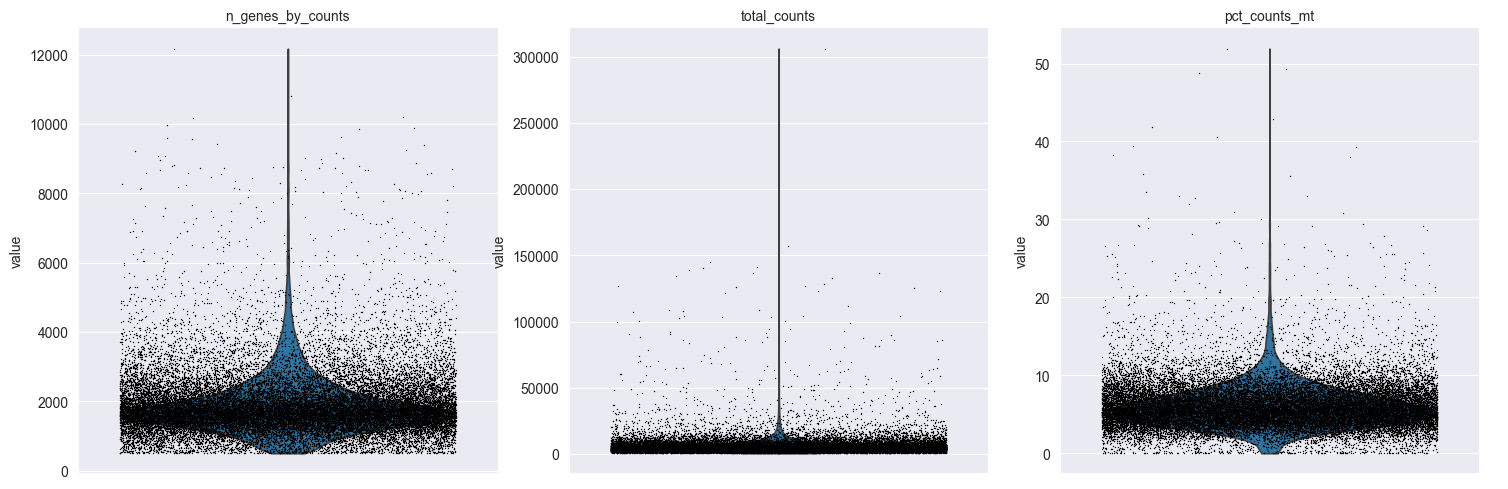

In [32]:
sc.pl.violin(
    adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4, multi_panel=True
)

*Notes from Scanpy tutorial:*
* Based on the QC metric plots, one could now remove cells that have too many mitochondrial genes expressed or too many total counts by setting manual or automatic thresholds. 
* However, sometimes what appears to be poor QC metrics can be driven by real biology so we suggest starting with a very permissive filtering strategy and revisiting it at a later point.

### Filter

Filter genes and cells in `adata`:
* Genes that are expressed in fewer than 10 cells should be filtered out.
* Cells that express fewer than 200 genes should be filtered out.

*Notes:*
* Filtering genes helps to reduce noise by eliminating genes with very low expression across the dataset. 
* Filtering cells helps to remove low-quality or potential empty droplets in the scRNA-seq data.

In [33]:
# sc.pp.filter_genes is a function from the scanpy library that filters genes based on their expression across cells
# min_cells is the minimum number of cells a gene must be expressed in to be retained
sc.pp.filter_genes(adata, min_cells=10)
# sc.pp.filter_cells is a function from the scanpy library that filters cells based on the number of genes they express
# min_genes is the minimum number of genes a cell must express to be retained
sc.pp.filter_cells(adata, min_genes=200)

In [34]:
adata # The n_genes and n_cells columns have been added

AnnData object with n_obs × n_vars = 29736 × 20589
    obs: 'CellID', 'SampleID', 'donor_id', 'nGene', 'nUMI', 'sex', 'library_preparation_protocol__ontology_label', 'biosample_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'Genes', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

### Doublets

One common occurrence is that one droplet captures more than one cell. Scanpy embeds the scrublet algorithm that predicts based on simulated doublets.

In [35]:
# sc.pp.scrublet(adata)

In [36]:
# adata.obs['CellID'] = adata.obs['CellID'].astype(str)
# adata.obs['SampleID'] = adata.obs['SampleID'].astype(str)
# adata.obs['donor_id'] = adata.obs['donor_id'].astype(str)
# adata.obs['nGene'] = adata.obs['nGene'].astype(int)
# adata.obs['nUMI'] = adata.obs['nUMI'].astype(int)
# adata.obs['sex'] = adata.obs['sex'].astype(str)
# adata.obs['library_preparation_protocol__ontology_label'] = adata.obs['library_preparation_protocol__ontology_label'].astype(str)
# adata.obs['biosample_type'] = adata.obs['biosample_type'].astype(str)
#  
# # Export the AnnData object with scrublet to a checkpoint
# scrublet_checkpoint_dir = '../scrublet_checkpoint'
# os.makedirs(scrublet_checkpoint_dir, exist_ok=True) # Make directory if it doesn't already exist
# adata.write(f'{scrublet_checkpoint_dir}/uzquiano_d23_rna_scvi_cp.h5ad')

In [37]:
# Load AnnData object with scrublet
adata = sc.read('../scrublet_checkpoint/uzquiano_d23_rna_scvi_cp.h5ad')

Scrublet adds two extra columns to the `adata.obs` object:

In [38]:
adata.obs[['doublet_score', 'predicted_doublet']].head(3)

,doublet_score,predicted_doublet
0,0.007172,False
1,0.019227,False
2,0.025641,False


We could filter on doublets here, but it is smarter to check clusters later.

Before continuing, ensure that the primary data matrix (`X`) in the `AnnData` object is stored in a CSR format, which is important for large scRNA-seq datasets.

Create a new layer called `counts` in the `AnnData` object, storing a CSR format copy of the primary data matrix. Layers in `AnnData` are used to store different versions or transformations of the primary data matrix.

In [39]:
# Create a copy of the expression data matrix (X) to avoid modifying the original data directly
# scipy.sparse.csr_matrix converts the copied matrix to CSR format and assigns it back to adata.X
adata.X = scipy.sparse.csr_matrix(adata.X.copy())
# Create another copy of the expression data matrix to ensure that the data is the new layer is also a separate copy
# Conver the copied matrix to CSR format and assign to a new layer named counts
adata.layers['counts'] = scipy.sparse.csr_matrix(adata.X.copy())
#adata.layers['log2_counts'] = sc.pp.log1p(adata.layers['counts'].copy(), base=2)

## Dimensionality reduction and clustering

Train a Single-Cell Variational Inference (SCVI) model on the scRNA-seq data contained in the `AnnData` object, considering batch effects specified by `SampleID`. 

*Notes: SCVI model*
* The SCVI model is a probabilistic model used to analyse scRNA-seq data.
* SCVI leverages variational autoencoders (VAEs), a type of deep learning model, to capture the underlying structure and variability in high-dimension scRNA-seq data.
* **VAEs:**
    * VAEs are a type of generative model that learn a low-dimension latent representation of the data.
    * They consist of an encoder network that maps the high-dimensional input data to a low-dimensional latent space, and a decoder network that reconstructs the input data from the latent representation.
    * The latent space captures the underlying structure and variability in the data.
* **Negative Binomial Likelihood:**
    * scRNA-seq data are count data, often modelled using the negative binomial distribution to account for overdispersion (variance greater than the mean).
* **Batch effect correction:**
    * scRNA-seq experiments are often conducted in multiple batches, leading to batch-specific technical variations.
    * SCVI includes batch correction mechanisms by integrating batch information into the model.
* The learnt low-dimensional representation of the gene expression data can then be used for downstream analysis such as dimensionality reduction (low-dimensional representation of the data for visualisation), clustering (identifying distinct cell populations based on their gene expression profiles) and differential expression analysis (identifying genes that are differentially expressed between different cell types or conditions).
* **Parameters:**
    * **n_layers:** the number of hidden layers in the encoder and decoder neural networks. Increasing the number of layers can allow the model to capture more complex patterns in the data but also increases the computational cost and risk of overfitting.
    * **n_latent:** the dimensionality of the latent space. The latent space is a lower-dimensional representation of the data learned by the model. A higher number of dimensions can capture more variation but also required more parameters to be learned.
    * **n_hidden:** the number of hidden units in each hidden layer of the encoder and decoder neural networks. More hidden units increase the capacity of the model to learn complex patterns, but also increase the computational cost and risk of overfitting.
    * **gene_likelihood:** the likelihood model used for gene expression. The choice of likelihood model determines how the model interprets the distribution of gene expression counts.

In [40]:
# %%time
# random.seed(17)
# # Prepare the AnnData object for use with the SCVI model
# # Specify that the data for the model should be taken from the counts layer
# # Specify the column in the obs dataframe that contains batch information
# scvi.model.SCVI.setup_anndata(adata, layer='counts', batch_key='SampleID')
# # Initialise the SCVI model using scvi.model.SCVI
# scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, n_hidden=128, gene_likelihood='nb')
# # Train the SCVI model
# scvi_model.train()

In [41]:
# # Save the SCVI model at a checkpoint
# scvi_model.save('../scvi_model_checkpoint', overwrite=True)

In [42]:
# Load the previously saved SCVI model
scvi_model = scvi.model.SCVI.load('../scvi_model_checkpoint', adata=adata) # The adata parameter is necessary when loading the model to ensure it has the correct AnnData object associated with it

INFO     File ../scvi_model_checkpoint/model.pt already downloaded                                                 


### Latent representation & normalisation

Use the trained SCVI model to obtain a latent representation of the data and normalise the gene expression counts.

*Notes: Latent representation*
* A latent representation refers to a lower-dimensional space where the data is represented by a set of features that capture the most significant aspects of the original high-dimensional data.
* In the context of scRNA-seq data, the latent representation is a learned, compressed version of the gene expression data that retains essential biological information while reducing noise and complexity.
* **Dimensionality reduction:**
    * The orgininal gene expression matrix can have thousands of genes (features) for each cell (observation), resulting in a very high-dimensional space.
    * Dimensionality reduction techniques, such as those used in SCVI, transform this high-dimensional data into a lower-dimensional space with fewer features while preserving the important structure and variability of the data.
* **VAE:**
    * SCVI uses a type of deep learning model called a VAE to learn the latent representation.
* **Capturing biological variability:**
    * The latent space learned by SCVI aims to capture the underlying biological variability in the data, such as different cell types, states or conditions.
    * The compressed representation helps to highlight meaningful patterns and relationships that might be obscured by noise or technical variability in the original high-dimensional data.

*Notes: Normalisation*
* Library size normalisation is the process of adjusting raw gene expression counts to account for differences in sequencing depth (total number of reads/unique molecular identifiers (UMIs) per cell).
* Cells in scRNA-seq experiments can have varying sequencing depths due to technical differences or biological variability.
* A common practice is the normalise the expression data to a fixed library size, often 10,000 reads/UMIs per cell (this is somewhat arbitrary).
* Normalisation typically involves the following steps:
    * **Calculate size factors:** determine a size factor for each cell, which is the total number of reads/UMIs for that cell.
    * **Scale counts:** adjust each gene's count in each cell by dividing by the cell;s size factor and then multiplying by the chosen library size.

In [43]:
random.seed(17)
# Extract the low-dimensional latent representation of the data learned by the SCVI model and store in the obsm attribute of the AnnData object, under the key 'X_scvi'
# The obsm (observation multi-dimensional) attribute is a dictionary that can hold arrays such as dimensionality reduction results
adata.obsm['X_scvi'] = scvi_model.get_latent_representation()
# Normalise the expression counts by a specified library size (e.g. 10,000 reads per cells) to adjust for differences in sequencing depth across cells
# Store the normalised expression data in the layers attribute of the AnnData object, under the key 'counts_scvi'
# The layers attribute is a dictionary that can hold multiple versions of the expression data, such as raw counts, normalised counts, and imputed counts
adata.layers['counts_scvi'] = scvi_model.get_normalized_expression(library_size=10000)

The latent representation `X_scvi` contains the latent representation of the cells, which can be used for visualisation (e.g. UMAP, t-SNE) or clustering.

The normalised expression `counts_scvi` contains the normalised gene expression counts, which can be used for differential expression analysis.

### Clustering

Perform clustering and visualisation of the scRNA-seq data using the SCVI model's latent representation.

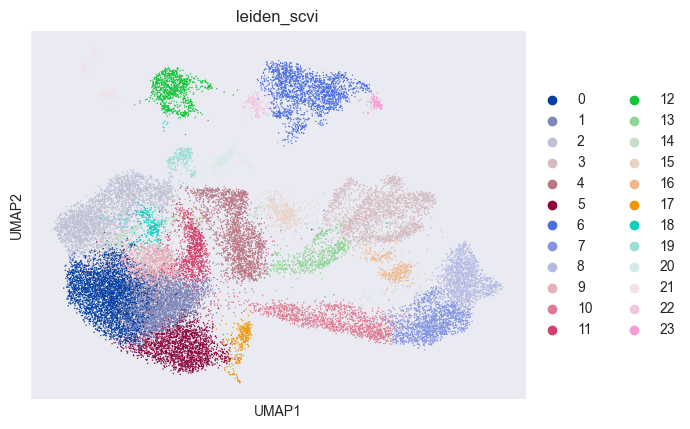

CPU times: user 1min, sys: 2.32 s, total: 1min 3s
Wall time: 1min 1s


In [44]:
%%time
# Compute the neighborhood graph of observations (cells)
# use_rep='X_scvi' uses the SCVI latent representation for computing neighbors
# key_added='neighbors_scvi' stores the computed neighborhood graph in adata.uns with the key 'neighbors_scvi'
# n_neighbors=20 specifies the number of neighbors to consider for each cell
sc.pp.neighbors(adata, use_rep='X_scvi', key_added='neighbors_scvi', n_neighbors=20)
# Perform Leidan clustering to identify clusters of cells
# neighbours_key='neighbours_scvi' uses the previously computed neighborhood graph for clustering
# key_added='leiden_scvi' stores the cluster labels in adata.obs with the key 'leiden_scvi'
# resolution=1 specifies the resolution parameter for the Leiden algorithm - higher values lead to more clusters
sc.tl.leiden(adata, neighbors_key='neighbors_scvi', key_added='leiden_scvi', resolution=1)
# Compute a UMAP embedding for visualisation using the neighborhood graph (neighbors_scvi)
# UMAP coodinates are stored in adata.obsm with the key `X_umap`
sc.tl.umap(adata, neighbors_key='neighbors_scvi')
# Plot the UMAP embedding colouring the cells based on the Leiden clustering labels (leidan_scvi)
sc.pl.umap(adata, color=['leiden_scvi'])

### Interpretation of the UMAP plot

This is a UMAP plot, which visualises the cells in two-dimensional space:
* Each point represents a cell, positioned according to the UMAP embedding.
* The points are coloured based on their Leidan cluster labels, where each cluster is assigned a different colour.

*Notes: How many clusters?*
* The number of clusters we got is high. Deciding on how many clusters you should have is non trivial, and can depend on multiple factors:
    * Complexity of the dataset - a set with all brain cells (instead of just microglia) will have many more clusters.
    * Your scientific question - do you really need to see all subclusters? You may not care about all microglia cellstates if you are 'just' after microgliosi.
* However:
* `resolution` is just a parameter
* Contaminations and low quality cells can also produce cluster - we hardly filtered earlier on. This is a good moment to reassess if we need to filter more.

In [45]:
adata.obs # The _scvi_batch, _scvi_labels and leiden_scvi columns have been added
# _scvi_batch is an internal column created by `scvi-tools` during the setup of the `AnnData` object for the SCVI model. It encodes batch information based on the `SampleID` column and is used by the SCVI model to account for batch effects during training.
# _svci_labels is an internal column created by `scvi-tools` during the set of the `AnnData` object for the SCVI model. It typically encodes the labels used by the SCVI model during training.
# leiden_scvi contains the cluster labels assigned to each cell by the Leiden clustering algorithm.

,CellID,SampleID,donor_id,nGene,nUMI,sex,library_preparation_protocol__ontology_label,biosample_type,n_genes_by_counts,log1p_n_genes_by_counts,...,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,n_genes,doublet_score,predicted_doublet,_scvi_batch,_scvi_labels,leiden_scvi
0,1_AAACGAACACGTGAGA-1_1_23d,Org1,Mito 210 c1 b1,536,3724,male,10X sequencing,DerivedType_Organoid,536,6.285998,...,2.873255,2614,7.869019,70.193340,536,0.007172,False,0,0,20
1,1_AAACGAAGTCGAAACG-1_1_23d,Org1,Mito 210 c1 b1,2310,9184,male,10X sequencing,DerivedType_Organoid,2310,7.745436,...,5.858014,3893,8.267192,42.388937,2310,0.019227,False,0,0,0
2,1_AAACGAAGTGGCAGAT-1_1_23d,Org1,Mito 210 c1 b1,2070,6359,male,10X sequencing,DerivedType_Organoid,2070,7.635787,...,6.211669,1037,6.945051,16.307596,2068,0.025641,False,0,0,3
3,1_AAACGAAGTGGTTCTA-1_1_23d,Org1,Mito 210 c1 b1,1292,3468,male,10X sequencing,DerivedType_Organoid,1292,7.164720,...,7.785467,896,6.799056,25.836217,1291,0.010556,False,0,0,13
4,1_AAACGAAGTTGGCCGT-1_1_23d,Org1,Mito 210 c1 b1,832,1809,male,10X sequencing,DerivedType_Organoid,832,6.725034,...,0.386954,231,5.446737,12.769486,831,0.018071,False,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29731,3_TTTGGTTTCGGAATGG-1_2_23d,Org6,PGP1 c1 b2,995,1825,male,10X sequencing,DerivedType_Organoid,995,6.903747,...,5.863014,396,5.983936,21.698630,994,0.008345,False,5,0,10
29732,3_TTTGGTTTCGGTTAGT-1_2_23d,Org6,PGP1 c1 b2,3449,13964,male,10X sequencing,DerivedType_Organoid,3449,8.146130,...,4.611859,5503,8.613230,39.408479,3449,0.129771,False,5,0,2
29733,3_TTTGTTGAGACCATAA-1_2_23d,Org6,PGP1 c1 b2,1382,3670,male,10X sequencing,DerivedType_Organoid,1382,7.232010,...,2.234332,1457,7.284821,39.700272,1382,0.011768,False,5,0,1
29734,3_TTTGTTGAGAGAAGGT-1_2_23d,Org6,PGP1 c1 b2,1331,3713,male,10X sequencing,DerivedType_Organoid,1331,7.194437,...,3.797468,1533,7.335634,41.287369,1329,0.039167,False,5,0,0


### Visualisation of quality stats in the UMAP

Visualise the quality statistics generated earlier in the UMAP: `n_genes_by_counts`, `pct_counts_mt`, `doublet_score`.

If you decide that there are contaminations (regions/clusters with very bad quality score) - take note, remove them from the `adata` object and repeat QC and dimensionality reduction.

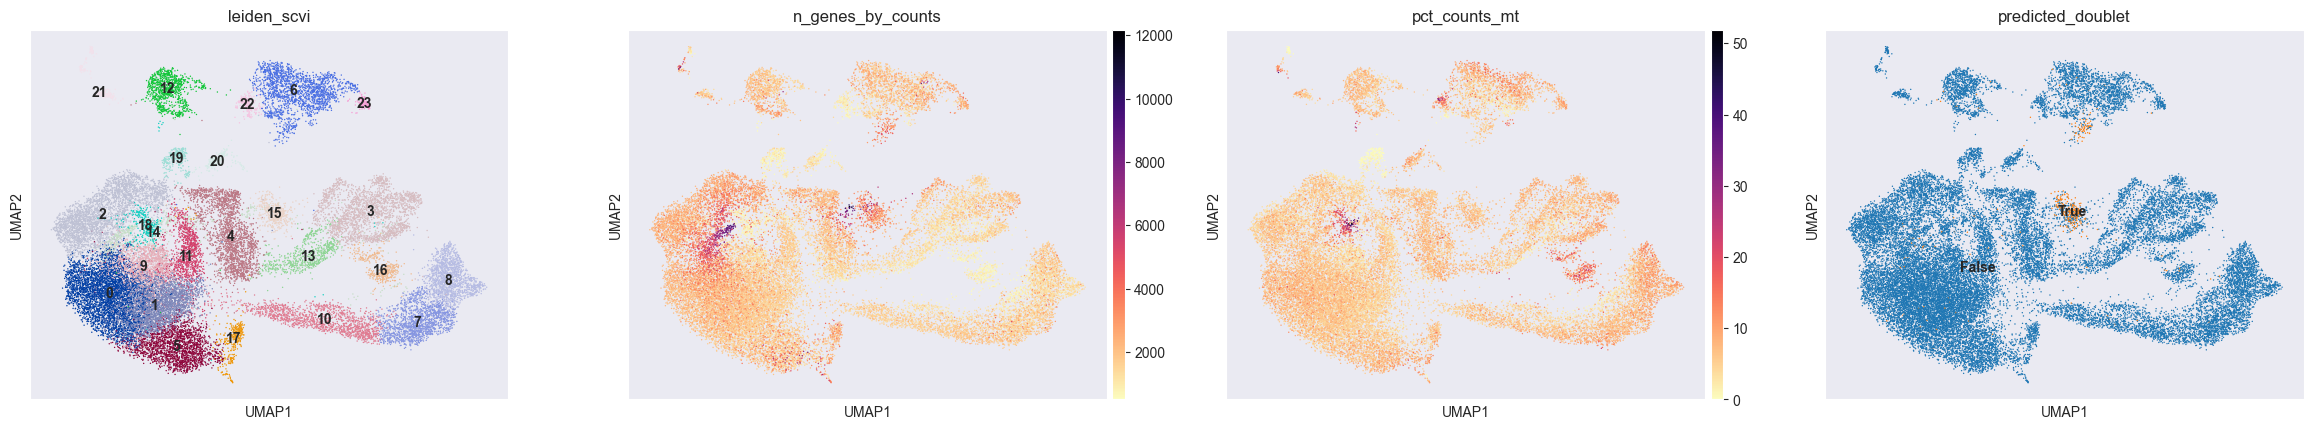

In [46]:
sc.pl.umap(adata, color=["leiden_scvi", "n_genes_by_counts", "pct_counts_mt", "predicted_doublet"], cmap='magma_r', legend_loc='on data')

## Export the AnnData object and SCVI model

Ensure each column in the `obs` attribute of the `AnnData` object has the correct data types. This is done to improve memory efficiency.

In [47]:
adata.obs['CellID'] = adata.obs['CellID'].astype(str)
adata.obs['SampleID'] = adata.obs['SampleID'].astype(str)
adata.obs['donor_id'] = adata.obs['donor_id'].astype(str)
adata.obs['nGene'] = adata.obs['nGene'].astype(int)
adata.obs['nUMI'] = adata.obs['nUMI'].astype(int)
adata.obs['sex'] = adata.obs['sex'].astype(str)
adata.obs['library_preparation_protocol__ontology_label'] = adata.obs['library_preparation_protocol__ontology_label'].astype(str)
adata.obs['biosample_type'] = adata.obs['biosample_type'].astype(str)
adata.obs['leiden_scvi'] = adata.obs['leiden_scvi'].astype(str)

Export the AnnData object and SCVI model.

In [48]:
%%time
os.makedirs(outs_dir, exist_ok=True) # Make directory if it doesn't already exist
adata.write(f'{outs_dir}/uzquiano_d23_rna_scvi.h5ad')
scvi_model.save(f'{outs_dir}/uzquiano_d23_rna_scvi_model', overwrite=True)

... storing 'SampleID' as categorical
... storing 'donor_id' as categorical
... storing 'sex' as categorical
... storing 'library_preparation_protocol__ontology_label' as categorical
... storing 'biosample_type' as categorical
... storing 'leiden_scvi' as categorical


CPU times: user 247 ms, sys: 3.15 s, total: 3.4 s
Wall time: 26 s


## Understanding the clusters

Given that we now have clusters - how do we interpret these?
* Which genes are different between clusters?
* What are the different clusters (cell type and state)?
* How do they differ across conditions (age/genotype)?

### Log transformation

Log transform the `counts` and `counts_scvi` layers.

*Notes:*
* In scRNA-seq data, gene expression values can have a large dynamic range - the log transformation helps to reduce skewness and make the data more amenable to analysis.
* The logarithm base 2 of a number y is the power to which the base 2 must be raised to obtain the number y.
* Before applying the logarthim, 1 is added to x to ensure that the argument of the logarithm is always positive, even is x is 0 or a small positive number.
* Taking the logarithm of (1 + x) helps to stabilise the variance of the data, especially in cases when x can span several orders of magnitude (such as RNA-seq counts).
* Log transformation compresses the range of data and can make it more normally distributed.

In [49]:
# Log transform the counts_scvi layer and assign it to a new layer of the AnnData object, log2_counts
# sc.pp.log1p() performs a log1p transformation (logarithm of one plus the input) from the scanpy preprocessing module (sc.pp)
# adata.layers['counts'].copy makes a copy of the counts layer to avoid modifying the original data
# base=2 specifies the base of the logarithm to be 2 - the log1p function will compute the log base 2 of (1 + x) for each element x in the copied counts layer
adata.layers['log2_counts'] = sc.pp.log1p(adata.layers['counts'].copy(), base=2)
# Log transform the counts_scvi layer and assign it to a new layer of the AnnData object, log2_counts_scvi
adata.layers['log2_counts_scvi'] = sc.pp.log1p(adata.layers['counts_scvi'].copy(), base=2)

In [50]:
adata

AnnData object with n_obs × n_vars = 29736 × 20589
    obs: 'CellID', 'SampleID', 'donor_id', 'nGene', 'nUMI', 'sex', 'library_preparation_protocol__ontology_label', 'biosample_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'doublet_score', 'predicted_doublet', '_scvi_batch', '_scvi_labels', 'leiden_scvi'
    var: 'Genes', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors_scvi', 'leiden_scvi', 'umap', 'leiden_scvi_colors', 'predicted_doublet_colors'
    obsm: 'X_scvi', 'X_umap'
    layers: 'counts', 'counts_scvi', 'log2_coun

Two new layers were created in the AnnData object `adata`:
* `log2_counts`: contains the log base 2 transformed values of the `counts` layer.
* `log2_counts_scvi`: contains the log base 2 transformed values of the `counts_scvi` layer.

Create a UMAP plot of the data in the `adata` object, colouring the data points according the `leiden_scvi` clustering results. The Leiden algorithm is used for community detection in networks, often applied to clustering cells in scRNA-seq data. This plot helps to understand how cells are grouped based on their expression profiles and how these groups are distributed in the reduced dimensional space provided by UMAP.

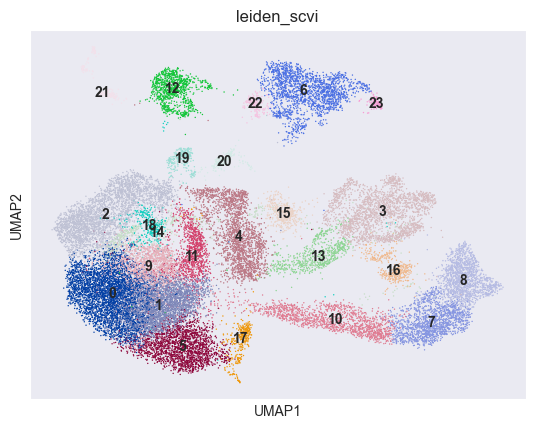

In [51]:
sc.pl.umap(adata, color=['leiden_scvi'], legend_loc='on data')

Create a UMAP plot of the data in the `adata` object, colouring the data points according the `SampleID` metadata. Each point (representing a cell) will be coloured based on which sample it belongs to. This plot helps to understand how cells from different samples are distributed in the reduced dimensional space provided by UMAP, and whether there are distinct clusters or overlap between samples.

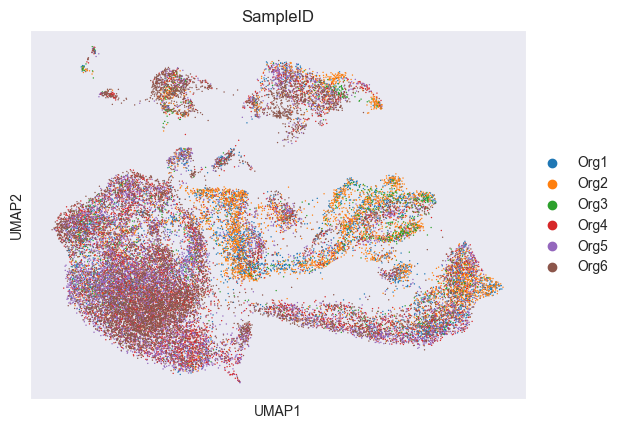

In [52]:
sc.pl.umap(adata, color=['SampleID'])

## Differential expression

Once we have done clustering, we want to find genes that are differential in each cluster. Identify marker genes for each cluster using `sc.tl.rank_genes_groups`. Marker genes are genes that are significantly expressed in one cluster compared to the others.

*Note:* we're performing DE on `leiden_scvi` clustering - you can use other parameters such as genotype or age if available.

In [53]:
%%time
# Use Wilcoxon rank-sum test to identify differentially expressed genes for clusters (defined by leiden_scvi labels)
# Wilcoxon suffices for transcriptomic differential expression in Python - note it vastly exaggerates p-values
sc.tl.rank_genes_groups(adata, 'leiden_scvi', method='wilcoxon', layer='log2_counts_scvi') # Specify which counts layer of the AnnData object to use (normalised and log-transformed)

CPU times: user 1min 29s, sys: 1min 23s, total: 2min 52s
Wall time: 8min 8s


/Users/laurahuggon/PycharmProjects/figureonelab/venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/laurahuggon/PycharmProjects/figureonelab/venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/laurahuggon/PycharmProjects/figureonelab/venv/lib/python3.10/site-pa

The results of the marker gene ranking, including the scores, p-values and log-fold changes, are stored in the `uns` attribute of the `AnnData` object. They are stored in a dictionary under the key `rank_genes_groups`.

In [54]:
adata

AnnData object with n_obs × n_vars = 29736 × 20589
    obs: 'CellID', 'SampleID', 'donor_id', 'nGene', 'nUMI', 'sex', 'library_preparation_protocol__ontology_label', 'biosample_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'doublet_score', 'predicted_doublet', '_scvi_batch', '_scvi_labels', 'leiden_scvi'
    var: 'Genes', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors_scvi', 'leiden_scvi', 'umap', 'leiden_scvi_colors', 'predicted_doublet_colors', 'SampleID_colors', 'rank_genes_groups'
    obsm: 'X_scvi', 'X_umap'
    lay

### Visualising cluster marker genes

Based on the DE, we have genes that are different between clusters. Plot the top 2 marker genes for each cluster on a dotplot.

*Notes: Dendrogram*
* A dendrogram is a tree-like diagram that is used to illustrate the arrangement of the clusters produced by hierarchical clustering.
* Branches connect the nodes (clusters) and represent the hierarchical relationships.

*Notes: Dotplot*
* The function `sc.pl.rank_genes_groups_dotplot` uses the data stored in `adata.uns['rank_genes_groups']` to create the dotplot. It automatically accesses this information to plot the expression levels of the top marker genes for each cluster.

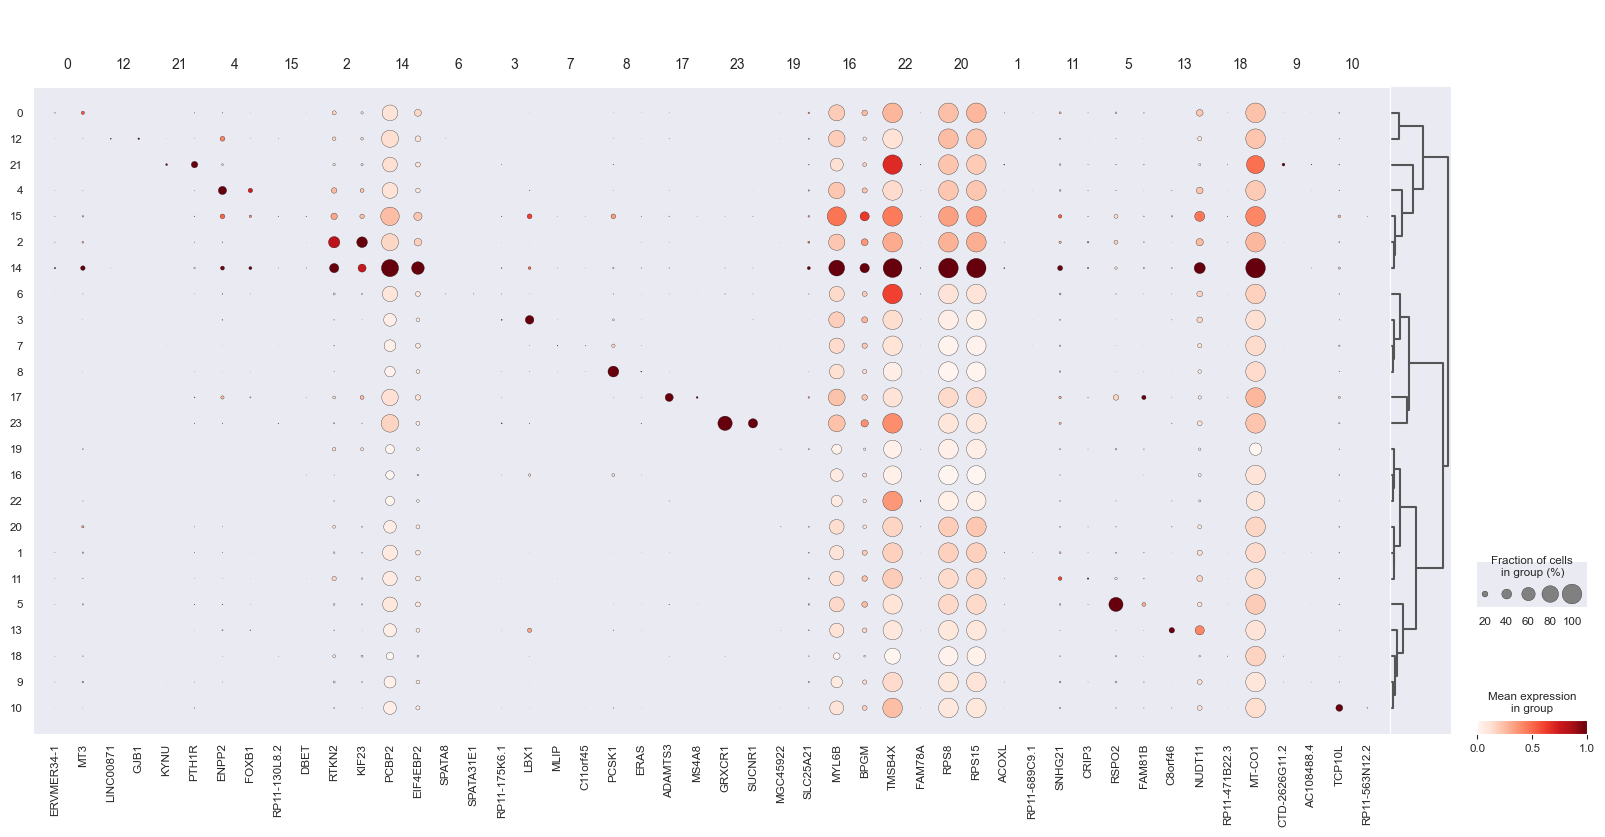

In [55]:
# Ensure the data matrix is in floating-point format
adata.X = adata.X.astype(float)
# Calculate dendrogram based on the clusters identified by leiden_scvi labels
sc.tl.dendrogram(adata, groupby='leiden_scvi')
# Plot the top 2 marker genes for each cluster (defined by leiden_scvi labels)
# standard_scale='var' standarises the expression values of each gene to have a mean of 0 and a variance of 1
sc.pl.rank_genes_groups_dotplot(
    adata, groupby='leiden_scvi', standard_scale='var', n_genes=2
)

Change the dotplot to a matrixplot plot.

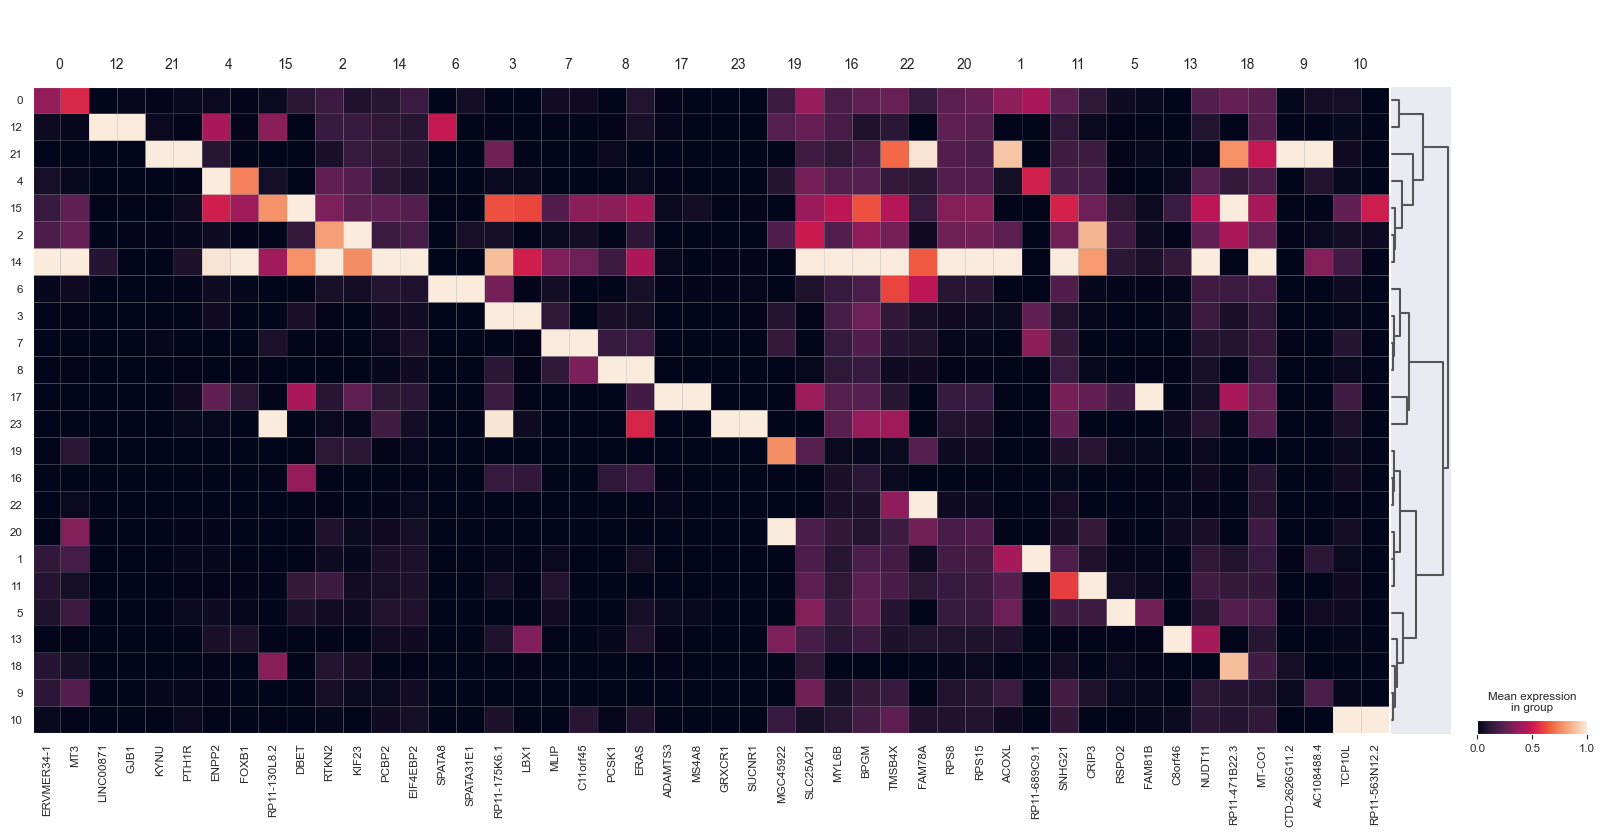

In [56]:
# Calculate dendrogram based on the clusters identified by leiden_scvi labels
sc.tl.dendrogram(adata, groupby='leiden_scvi')
# Plot the top 2 marker genes for each cluster (defined by leiden_scvi labels)
# standard_scale='var' standarises the expression values of each gene to have a mean of 0 and a variance of 1
sc.pl.rank_genes_groups_matrixplot(
    adata, groupby='leiden_scvi', standard_scale='var', n_genes=2
)

### Export marker genes

Export the marker genes to tsv files for further analysis.

Also create a dictionary (`topgenes`) with the top 50 genes for each cluster for later analysis.

*Notes: Dictionaries*
* Dictionaries are a data structure for mapping keys to values: `dictionary_name = {'key':value}`.
* Values are accessed via square bracket syntax: `dictionary_name['key']`.
* Use the same syntax to add another key, value pair: `dictionary_name['key2'] = value`.
* For example, in the loop:
    * `result['names']`: `result` is a dictionary, so `['name']` accesses this key, which maps to an array of marker gene names for all clusters. The array is structured, meaning it contains data for multiple clusters in a structured format.
    * `[cluster]`: is used to index into the structure array for a specific cluster.

In [57]:
# Access the results of the marker gene ranking
result = adata.uns['rank_genes_groups']
# result['names'] accesses the array of marker gene names from result
# .dtype.names retrieves the names of the columns in the array, which correspond to the names of the clusters (from which the marker genes were identified)
# The clusters variable contains a list of cluster names (i.e. 0-number of clusters)
clusters = result['names'].dtype.names
# Initialise a dictionary to store top genes
topgenes = {}

outs_clusters_dir = '../outs/clusters'
os.makedirs(outs_clusters_dir, exist_ok=True) # Make directory if it doesn't already exist

# Iterate over each cluster in the clusters list to extract its marker genes
for cluster in clusters:
    # de_results holds the differential expression results for the current cluster
    de_results = pd.DataFrame({ # Create a new pandas DataFrame
        # Retrieve the names of the marker genes for the current cluster and store under a colum named 'names'
        'names': result['names'][cluster], 
         # Retrieve the log-fold changes of the marker genes for the current cluster and store under a colum named 'lcf'
        'lfc': result['logfoldchanges'][cluster],
         # Retrieve the adjusted p-values of the marker genes for the current cluster and store under a colum named 'padj'
        'padj': result['pvals_adj'][cluster],
    })    
    # Sort by LFC (log-fold change) in descending order
    de_results = de_results.sort_values(by='lfc', ascending=False)
    # Retrieve the top 50 marker genes from the sorted de_results dataframe, convert the gene names to a list, and store in the topgenes dictionary
    topgenes[cluster] = list(de_results.head(50)['names']) # de_results is a DataFrame, so ['names'] selects this column from the DataFrame
    # Save to a TSV file, one for each cluster
    de_results.to_csv(f'{outs_clusters_dir}/cluster_{cluster}.tsv', sep='\t', index=False)

Export the AnnData object.

In [58]:
adata.write(f'{outs_dir}/uzquiano_d23_rna_scvi.h5ad')

In [59]:
# Load previously saved AnnData object if required
adata = sc.read_h5ad(f'{outs_dir}/uzquiano_d23_rna_scvi.h5ad')

### Annotation

Based on the CellTypist tutorial, we need to prepare our data so that counts are normalised to 10,000 counts per cell, then log1p-transformed.

In [60]:
# Make a copy of our data
adata_celltypist = adata.copy()
# Set adata_celltypist.X to raw counts, converted to float
adata_celltypist.X = adata_celltypist.layers["counts"].astype(np.float64)
# Normalise to 10,000 counts per cell
sc.pp.normalize_per_cell(adata_celltypist, counts_per_cell_after=10**4)
# Log transform
sc.pp.log1p(adata_celltypist)
# Make .X dense instead of sparse, for compatibility with celltypist
adata_celltypist.X = adata_celltypist.X.toarray()

Now download the celltypist model for the developing human brain.

In [61]:
models.download_models(force_update=True, model=["Developing_Human_Brain.pkl"])

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 52
📂 Storing models in /Users/laurahuggon/.celltypist/data/models
💾 Total models to download: 1
💾 Downloading model [1/1]: Developing_Human_Brain.pkl


In [62]:
annotation_model = models.Model.load(model="Developing_Human_Brain.pkl")

See which cell types are included.

In [63]:
annotation_model.cell_types

array(['Brain erythrocytes', 'Brain fibroblasts', 'Brain immune cells',
       'Brain neuroblast', 'Brain neuron', 'Brain neuronal IPC',
       'Brain placode cells', 'Brain radial glia', 'Brain vascular cells',
       'Cerebellum glioblast', 'Cerebellum immune cells',
       'Cerebellum neural crest cells', 'Cerebellum neuroblast',
       'Cerebellum neuron', 'Cerebellum neuronal IPC', 'Cerebellum OPC',
       'Cerebellum radial glia', 'Cortex glioblast',
       'Cortex immune cells', 'Cortex neuroblast', 'Cortex neuron',
       'Cortex neuronal IPC', 'Cortex OPC', 'Cortex radial glia',
       'Diencephalon glioblast', 'Diencephalon immune cells',
       'Diencephalon neuroblast', 'Diencephalon neuron',
       'Diencephalon neuronal IPC', 'Diencephalon radial glia',
       'Dorsal midbrain glioblast', 'Dorsal midbrain immune cells',
       'Dorsal midbrain neuroblast', 'Dorsal midbrain neuron',
       'Dorsal midbrain neuronal IPC', 'Dorsal midbrain OPC',
       'Dorsal midbrain radia

Run the model.

*Notes: CellTypist*
* `majority_voting=True` specifies that majority voting should be used to determine the final cell type annotation for each cell. Majority voting aggregates predictions from multiple classifiers or models to assign the most frequently predicted cell type to each cell.

In [64]:
# Rename neighborhood graph to the default names (not scvi-labelled names)
adata_celltypist.uns['neighbors'] = adata_celltypist.uns['neighbors_scvi']
adata_celltypist.obsp['connectivities'] = adata_celltypist.obsp['neighbors_scvi_connectivities']
adata_celltypist.obsp['distances'] = adata_celltypist.obsp['neighbors_scvi_distances']

predictions = celltypist.annotate(adata_celltypist, model=annotation_model, majority_voting=True)

🔬 Input data has 29736 cells and 20589 genes
🔗 Matching reference genes in the model
🧬 810 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


Transform the predictions to adata to get the full output.

In [65]:
# Convert the predictions obtained from celltypist.annotate to an AnnData object
predictions_adata = predictions.to_adata() 

Copy the cell type labels and confidence scores from `predictions_adata` into the original AnnData object.

In [66]:
# Locate the majority_voting column for the cells indexed by adata.obs.index (i.e. ensuring the labels are matched by cell identifiers)
adata.obs["celltypist_cell_label"] = predictions_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score"] = predictions_adata.obs.loc[
    adata.obs.index, "conf_score"
]

In [67]:
adata

AnnData object with n_obs × n_vars = 29736 × 20589
    obs: 'CellID', 'SampleID', 'donor_id', 'nGene', 'nUMI', 'sex', 'library_preparation_protocol__ontology_label', 'biosample_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'doublet_score', 'predicted_doublet', '_scvi_batch', '_scvi_labels', 'leiden_scvi', 'celltypist_cell_label', 'celltypist_conf_score'
    var: 'Genes', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'SampleID_colors', '_scvi_manager_uuid', '_scvi_uuid', 'dendrogram_leiden_scvi', 'leiden_scvi', 'leiden_scvi_colors', 'neighbors_scvi', 'pca', 'predicted_doublet_co

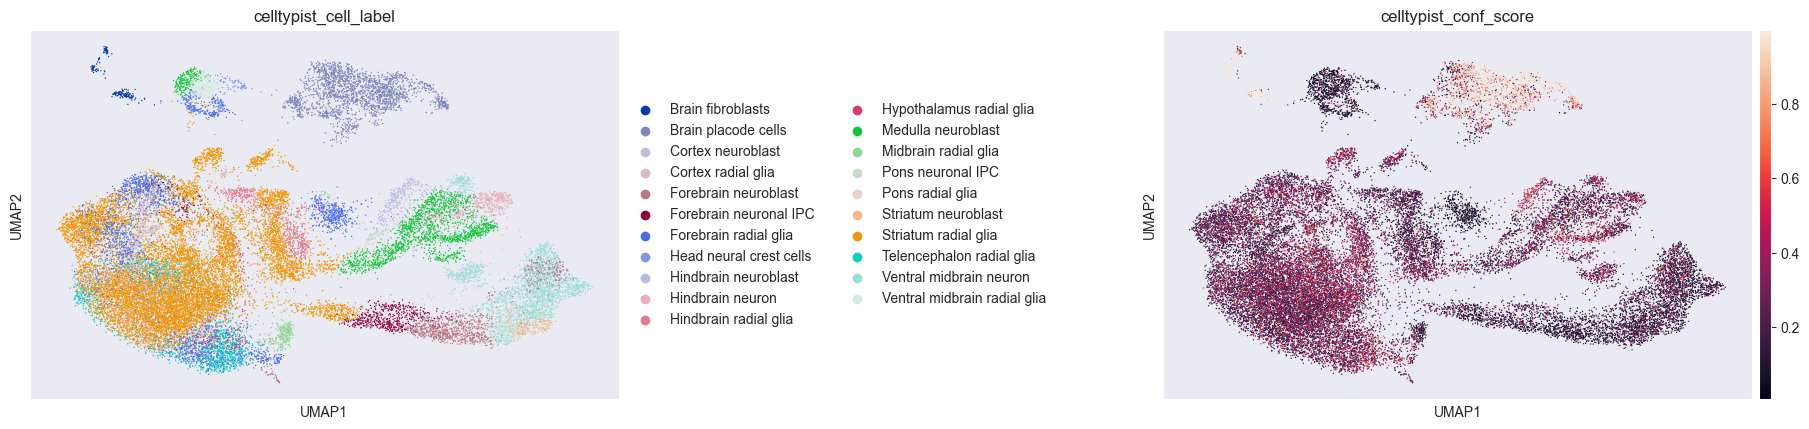

In [68]:
sc.pl.umap(adata, color=["celltypist_cell_label", "celltypist_conf_score"], wspace=0.75)